In [2]:
import argparse
import json
import logging
import pickle
import wandb

import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pandas as pd
import os
import numpy as np
import copy
from pprint import pprint

In [3]:
import matplotlib
matplotlib.rcParams.update(
    {
        "figure.dpi": 150,
        "font.size": 20,
    }
)
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [5]:
api = wandb.Api()

In [6]:
def load_groups(group_and_keys, relabel_dict, x_range, extra_filter, include_configs = None):
    all_interp_data = []
    if include_configs is None:
        include_configs = []
    for group, x_key, y_key, extra_cond in group_and_keys:
        total_filters = {
            "$and": [
                *extra_cond,
                {"group": group},
                {"$not": {"tags": "exclude-from-paper"}},
                extra_filter,
            ]
        }
        pprint(total_filters)
        runs = api.runs(
            path="resl-mixppo/stabilized-rl",
            filters=total_filters,
        )
        print(f"Got {len(runs)} runs for group {group}")
        x_vals = np.linspace(x_range[0], x_range[1], 1000)
        for r in runs:
            # h = r.history(samples=2000, keys=[x_key, y_key])
            h = pd.DataFrame(r.scan_history(keys=[x_key, y_key]))
            try:
                if np.max(h[x_key]) < 0.99 * x_range[1]:
                    print("Maximum x value of run", str(r), "is", np.max(h[x_key]))
                    continue
                interp_y = np.interp(x_vals, h[x_key], h[y_key])
            except KeyError:
                print("Could not get keys in run", r)
                print(h)
            else:
                df = pd.DataFrame.from_dict(
                        {
                            relabel_dict.get(x_key, x_key): x_vals,
                            relabel_dict.get(y_key, y_key): interp_y,
                            relabel_dict.get("group", "group"): relabel_dict.get(
                                group, group
                            ),
                            "run": str(r),
                        }
                    )
                for inc_cfg in include_configs:
                    df[relabel_dict.get(inc_cfg, inc_cfg)] = r.config.get(inc_cfg, None)
                all_interp_data.append(df)
    return pd.concat(all_interp_data, ignore_index=True)

In [39]:
env = "HalfCheetah"

relabels = {
    "fixpo-512-5": "xPPO",
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "xppo_single_step": "xPPO",
    "baseline_ppo_10m": "PPO-clip",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
    "fixpo-tianshou-mujoco": "FixPO",
    "ppo-tianshou-mujoco": "PPO-clip",
    "test/reward": "Average Episode Reward",
    "evaluation_reward/mean": "Average Episode Reward",
    "trust_region_layers" : "KL Proj.",
    "trust-region-layers-papi": "KL Proj.",
    "trpo-tianshou-mujoco": "TRPO",
}


fixpo_configs = {'fixup_loop': 1, 'fixup_every_repeat': 1, 'env': f'{env}-v3', 'eps_kl': 0.5, 'target_coeff': 3, "kl_target_stat": 'max'}
ppo_configs = {'env': f'{env}-v3'}
trl_zhehui = {'proj_type': 'kl', 'game': f'{env}-v2'}
trl_kr = {'proj_type': 'kl', 'game': f'{env}-v2'}
trpo_configs = {'env': f'{env}-v3'}


group_and_keys = [
    ("fixpo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in fixpo_configs.items()),]),
    ("ppo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in ppo_configs.items()),]),
    ("trust_region_layers", "global_step", "evaluation_reward/mean", [*({f"config.{k}": v} for k, v in trl_zhehui.items()),]),
    ("trust-region-layers-papi", "global_step", "evaluation_reward/mean", [*({f"config.{k}": v} for k, v in trl_kr.items()),]),
    ("trpo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in trpo_configs.items()),]),

]


all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 10e6),
    {
        "$and": [
            {"$or": [{"tags": {"$in": ['paper']}}, {"state": "finished"}, {"state": "running"}]},
        ]
    },
)

{'$and': [{'config.fixup_loop': 1},
          {'config.fixup_every_repeat': 1},
          {'config.env': 'HalfCheetah-v3'},
          {'config.eps_kl': 0.5},
          {'config.target_coeff': 3},
          {'config.kl_target_stat': 'max'},
          {'group': 'fixpo-tianshou-mujoco'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 10 runs for group fixpo-tianshou-mujoco
{'$and': [{'config.env': 'HalfCheetah-v3'},
          {'group': 'ppo-tianshou-mujoco'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 10 runs for group ppo-tianshou-mujoco
{'$and': [{'config.proj_type': 'kl'},
          {'config.game': 'HalfCheetah-v2'},
          {'group':

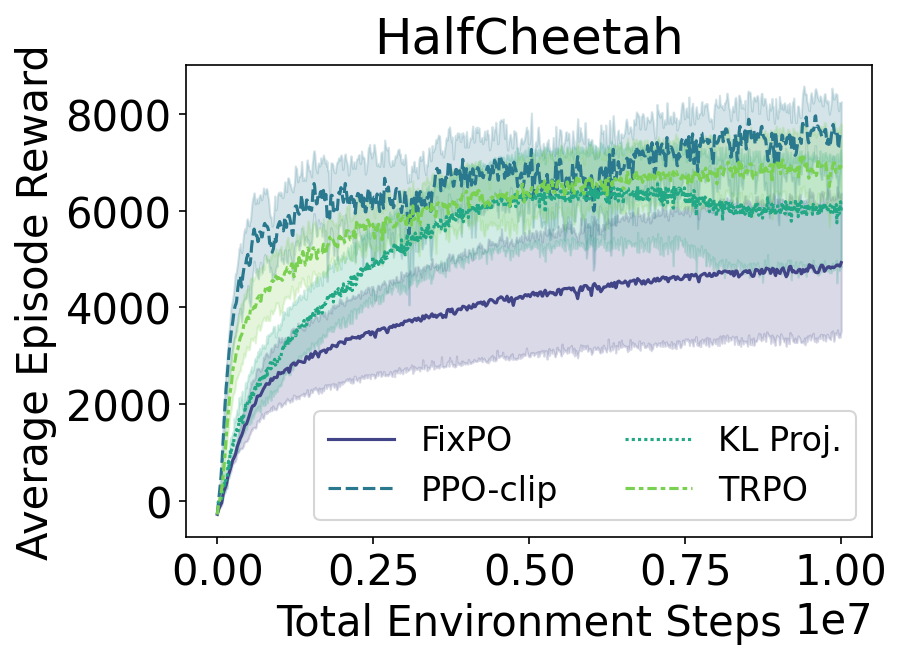

In [40]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Episode Reward",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right", ncol=2, prop={'size': 16})
plt.title(f"{env}")
plt.tight_layout()
plt.savefig(f"fixPo_vs_ppo_{env}.pdf", bbox_inches='tight')

In [29]:
env = "Hopper"

relabels = {
    "fixpo-512-5": "xPPO",
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "xppo_single_step": "xPPO",
    "baseline_ppo_10m": "PPO-clip",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
    "fixpo-tianshou-mujoco": "FixPO",
    "ppo-tianshou-mujoco": "PPO-clip",
    "test/reward": "Average Episode Reward",
    "evaluation_reward/mean": "Average Episode Reward",
    "trust_region_layers" : "KL Proj.",
    "trust-region-layers-papi": "KL Proj.",
    "trpo-tianshou-mujoco": "TRPO",

}

fixpo_configs = {'fixup_loop': 1, 'fixup_every_repeat': 1, 'env': f'{env}-v3', 'eps_kl': 0.5, 'target_coeff': 3, "kl_target_stat": 'max'}
ppo_configs = {'env': f'{env}-v3'}
trl_zhehui = {'proj_type': 'kl', 'game': f'{env}-v2'}
trl_kr = {'proj_type': 'kl', 'game': f'{env}-v2'}
trpo_configs = {'env': f'{env}-v3'}


group_and_keys = [
    ("fixpo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in fixpo_configs.items()),]),
    ("ppo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in ppo_configs.items()),]),
    ("trust_region_layers", "global_step", "evaluation_reward/mean", [*({f"config.{k}": v} for k, v in trl_zhehui.items()),]),
    ("trust-region-layers-papi", "global_step", "evaluation_reward/mean", [*({f"config.{k}": v} for k, v in trl_kr.items()),]),
    ("trpo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in trpo_configs.items()),]),

]


all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 10e6),
    {
        "$and": [
            {"$or": [{"tags": {"$in": ['paper']}}, {"state": "finished"}, {"state": "running"}]},
        ]
    },
)

{'$and': [{'config.fixup_loop': 1},
          {'config.fixup_every_repeat': 1},
          {'config.env': 'Hopper-v3'},
          {'config.eps_kl': 0.5},
          {'config.target_coeff': 3},
          {'config.kl_target_stat': 'max'},
          {'group': 'fixpo-tianshou-mujoco'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 10 runs for group fixpo-tianshou-mujoco
{'$and': [{'config.env': 'Hopper-v3'},
          {'group': 'ppo-tianshou-mujoco'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 10 runs for group ppo-tianshou-mujoco
{'$and': [{'config.proj_type': 'kl'},
          {'config.game': 'Hopper-v2'},
          {'group': 'trust_region_

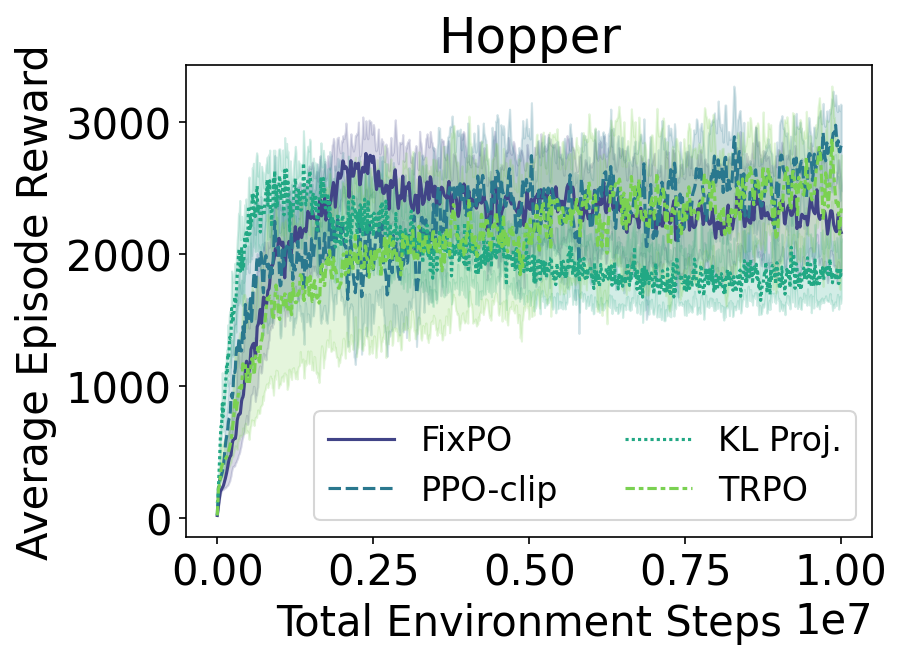

In [30]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Episode Reward",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right", ncol=2, prop={'size': 16})
plt.title(f"{env}")
plt.tight_layout()
plt.savefig(f"fixPo_vs_ppo_{env}.pdf", bbox_inches='tight')

In [31]:
env = "Reacher"

relabels = {
    "fixpo-512-5": "xPPO",
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "xppo_single_step": "xPPO",
    "baseline_ppo_10m": "PPO-clip",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
    "fixpo-tianshou-mujoco": "FixPO",
    "ppo-tianshou-mujoco": "PPO-clip",
    "test/reward": "Average Episode Reward",
    "evaluation_reward/mean": "Average Episode Reward",
    "trust_region_layers" : "KL Proj.",
    "trust-region-layers-papi": "KL Proj.",
    "trpo-tianshou-mujoco": "TRPO",

}

fixpo_configs = {'fixup_loop': 1, 'fixup_every_repeat': 1, 'env': f'{env}-v2', 'eps_kl': 0.5, 'target_coeff': 3, "kl_target_stat": 'max'}
ppo_configs = {'env': f'{env}-v2'}
trl_zhehui = {'proj_type': 'kl', 'game': f'{env}-v2'}
trl_kr = {'proj_type': 'kl', 'game': f'{env}-v2'}
trpo_configs = {'env': f'{env}-v2'}


group_and_keys = [
    ("fixpo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in fixpo_configs.items()),]),
    ("ppo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in ppo_configs.items()),]),
    ("trust_region_layers", "global_step", "evaluation_reward/mean", [*({f"config.{k}": v} for k, v in trl_zhehui.items()),]),
    ("trust-region-layers-papi", "global_step", "evaluation_reward/mean", [*({f"config.{k}": v} for k, v in trl_kr.items()),]),
    ("trpo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in trpo_configs.items()),]),

]

all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 10e6),
    {
        "$and": [
            {"$or": [{"tags": {"$in": ['paper']}}, {"state": "finished"}, {"state": "running"}]},
        ]
    },
)

{'$and': [{'config.fixup_loop': 1},
          {'config.fixup_every_repeat': 1},
          {'config.env': 'Reacher-v2'},
          {'config.eps_kl': 0.5},
          {'config.target_coeff': 3},
          {'config.kl_target_stat': 'max'},
          {'group': 'fixpo-tianshou-mujoco'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 10 runs for group fixpo-tianshou-mujoco
{'$and': [{'config.env': 'Reacher-v2'},
          {'group': 'ppo-tianshou-mujoco'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 10 runs for group ppo-tianshou-mujoco
{'$and': [{'config.proj_type': 'kl'},
          {'config.game': 'Reacher-v2'},
          {'group': 'trust_regi

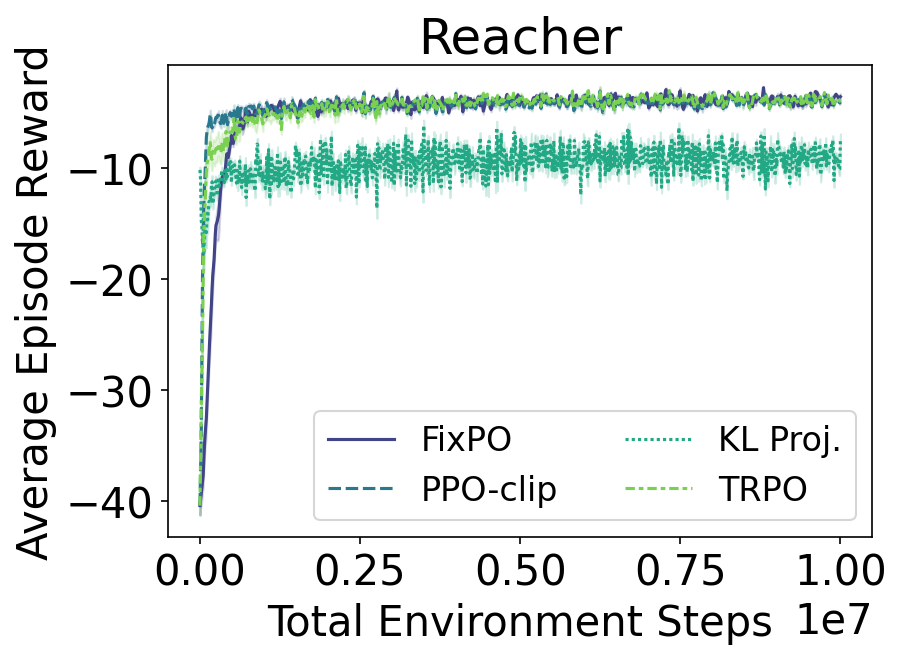

In [32]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Episode Reward",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right", ncol=2, prop={'size': 16})
plt.title(f"{env}")
plt.tight_layout()
plt.savefig(f"fixPo_vs_ppo_{env}.pdf", bbox_inches='tight')

In [33]:
env = "InvertedDoublePendulum"

relabels = {
    "fixpo-512-5": "xPPO",
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "xppo_single_step": "xPPO",
    "baseline_ppo_10m": "PPO-clip",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
    "fixpo-tianshou-mujoco": "FixPO",
    "ppo-tianshou-mujoco": "PPO-clip",
    "test/reward": "Average Episode Reward",
    "evaluation_reward/mean": "Average Episode Reward",
    "trust_region_layers" : "KL Proj.",
    "trust-region-layers-papi": "KL Proj.",
    "trpo-tianshou-mujoco": "TRPO",

}

fixpo_configs = {'fixup_loop': 1, 'fixup_every_repeat': 1, 'env': f'{env}-v2', 'eps_kl': 0.5, 'target_coeff': 3, "kl_target_stat": 'max'}
ppo_configs = {'env': f'{env}-v2'}
trl_zhehui = {'proj_type': 'kl', 'game': f'{env}-v2'}
trl_kr = {'proj_type': 'kl', 'game': f'{env}-v2'}
trpo_configs = {'env': f'{env}-v2'}


group_and_keys = [
    ("fixpo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in fixpo_configs.items()),]),
    ("ppo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in ppo_configs.items()),]),
    ("trust_region_layers", "global_step", "evaluation_reward/mean", [*({f"config.{k}": v} for k, v in trl_zhehui.items()),]),
    ("trust-region-layers-papi", "global_step", "evaluation_reward/mean", [*({f"config.{k}": v} for k, v in trl_kr.items()),]),
    ("trpo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in trpo_configs.items()),]),

]

all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 10e6),
    {
        "$and": [
            {"$or": [{"tags": {"$in": ['paper']}}, {"state": "finished"}, {"state": "running"}]},
        ]
    },
)

{'$and': [{'config.fixup_loop': 1},
          {'config.fixup_every_repeat': 1},
          {'config.env': 'InvertedDoublePendulum-v2'},
          {'config.eps_kl': 0.5},
          {'config.target_coeff': 3},
          {'config.kl_target_stat': 'max'},
          {'group': 'fixpo-tianshou-mujoco'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 10 runs for group fixpo-tianshou-mujoco
{'$and': [{'config.env': 'InvertedDoublePendulum-v2'},
          {'group': 'ppo-tianshou-mujoco'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 10 runs for group ppo-tianshou-mujoco
{'$and': [{'config.proj_type': 'kl'},
          {'config.game': 'InvertedDoubleP

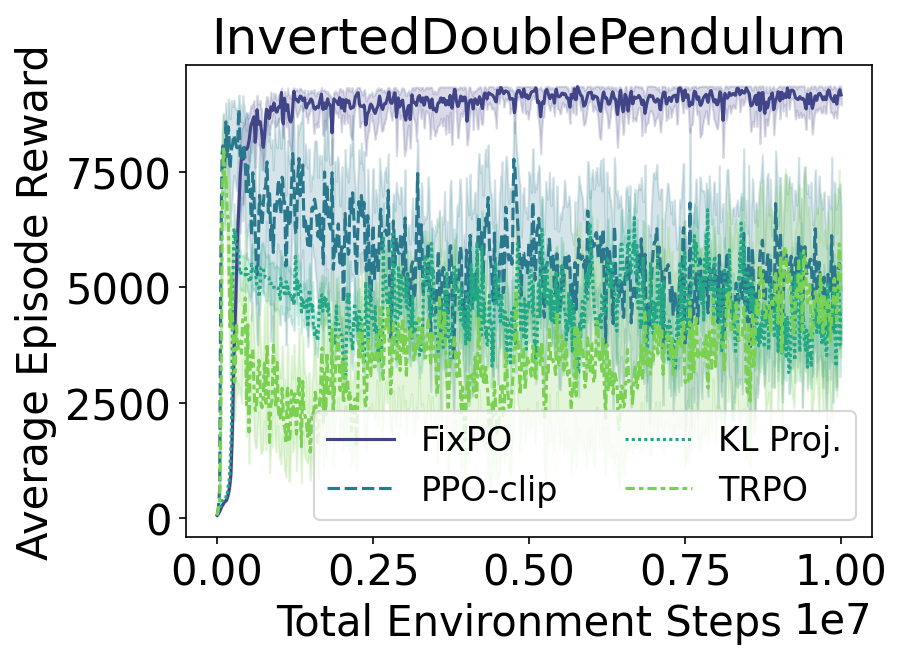

In [34]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Episode Reward",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right", ncol=2, prop={'size': 16})
plt.title(f"{env}")
plt.tight_layout()
plt.savefig(f"fixPo_vs_ppo_{env}.pdf", bbox_inches='tight')

In [35]:
env = "Swimmer"

relabels = {
    "fixpo-512-5": "xPPO",
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "xppo_single_step": "xPPO",
    "baseline_ppo_10m": "PPO-clip",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
    "fixpo-tianshou-mujoco": "FixPO",
    "ppo-tianshou-mujoco": "PPO-clip",
    "test/reward": "Average Episode Reward",
    "evaluation_reward/mean": "Average Episode Reward",
    "trust_region_layers" : "KL Proj.",
    "trust-region-layers-papi": "KL Proj.",
    "trpo-tianshou-mujoco": "TRPO",

}

fixpo_configs = {'fixup_loop': 1, 'fixup_every_repeat': 1, 'env': f'{env}-v3', 'eps_kl': 0.5, 'target_coeff': 3, "kl_target_stat": 'max'}
ppo_configs = {'env': f'{env}-v3'}
trl_zhehui = {'proj_type': 'kl', 'game': f'{env}-v2'}
trl_kr = {'proj_type': 'kl', 'game': f'{env}-v2'}
trpo_configs = {'env': f'{env}-v3'}


group_and_keys = [
    ("fixpo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in fixpo_configs.items()),]),
    ("ppo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in ppo_configs.items()),]),
    ("trust_region_layers", "global_step", "evaluation_reward/mean", [*({f"config.{k}": v} for k, v in trl_zhehui.items()),]),
    ("trust-region-layers-papi", "global_step", "evaluation_reward/mean", [*({f"config.{k}": v} for k, v in trl_kr.items()),]),
    ("trpo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in trpo_configs.items()),]),

]



all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 10e6),
    {
        "$and": [
            {"$or": [{"tags": {"$in": ['paper']}}, {"state": "finished"}, {"state": "running"}]},
        ]
    },
)

{'$and': [{'config.fixup_loop': 1},
          {'config.fixup_every_repeat': 1},
          {'config.env': 'Swimmer-v3'},
          {'config.eps_kl': 0.5},
          {'config.target_coeff': 3},
          {'config.kl_target_stat': 'max'},
          {'group': 'fixpo-tianshou-mujoco'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 10 runs for group fixpo-tianshou-mujoco
{'$and': [{'config.env': 'Swimmer-v3'},
          {'group': 'ppo-tianshou-mujoco'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 10 runs for group ppo-tianshou-mujoco
{'$and': [{'config.proj_type': 'kl'},
          {'config.game': 'Swimmer-v2'},
          {'group': 'trust_regi

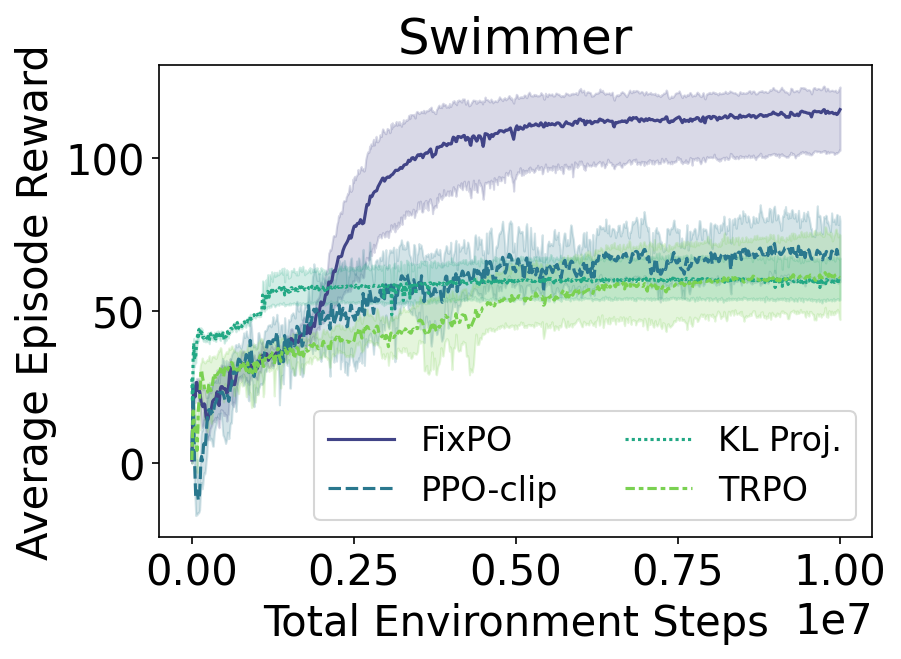

In [36]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Episode Reward",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right", ncol=2, prop={'size': 16})
plt.title(f"{env}")
plt.tight_layout()
plt.savefig(f"fixPo_vs_ppo_{env}.pdf", bbox_inches='tight')

In [37]:
env = "Walker2d"

relabels = {
    "fixpo-512-5": "xPPO",
    "baseline_ppo": "PPO-clip",
    "xppo10m-512-5": "xPPO",
    "xppo_single_step": "xPPO",
    "baseline_ppo_10m": "PPO-clip",
    "global_step": "Total Environment Steps",
    "rollout/ep_rew_mean": "Average Episode Reward",
    "group": "Algorithm",
    "fixpo-tianshou-mujoco": "FixPO",
    "ppo-tianshou-mujoco": "PPO-clip",
    "test/reward": "Average Episode Reward",
    "evaluation_reward/mean": "Average Episode Reward",
    "trust_region_layers" : "KL Proj.",
    "trust-region-layers-papi": "KL Proj.",
    "trpo-tianshou-mujoco": "TRPO",

}

fixpo_configs = {'fixup_loop': 1, 'fixup_every_repeat': 1, 'env': f'{env}-v3', 'eps_kl': 0.5, 'target_coeff': 3, "kl_target_stat": 'max'}
ppo_configs = {'env': f'{env}-v3'}
trl_zhehui = {'proj_type': 'kl', 'game': f'{env}-v2'}
trl_kr = {'proj_type': 'kl', 'game': f'{env}-v2'}
trpo_configs = {'env': f'{env}-v3'}


group_and_keys = [
    ("fixpo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in fixpo_configs.items()),]),
    ("ppo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in ppo_configs.items()),]),
    ("trust_region_layers", "global_step", "evaluation_reward/mean", [*({f"config.{k}": v} for k, v in trl_zhehui.items()),]),
    ("trust-region-layers-papi", "global_step", "evaluation_reward/mean", [*({f"config.{k}": v} for k, v in trl_kr.items()),]),
    ("trpo-tianshou-mujoco", "global_step", "test/reward", [*({f"config.{k}": v} for k, v in trpo_configs.items()),]),

]



all_data = load_groups(
    group_and_keys,
    relabels,
    (0, 10e6),
    {
        "$and": [
            {"$or": [{"tags": {"$in": ['paper']}}, {"state": "finished"}, {"state": "running"}]},
        ]
    },
)

{'$and': [{'config.fixup_loop': 1},
          {'config.fixup_every_repeat': 1},
          {'config.env': 'Walker2d-v3'},
          {'config.eps_kl': 0.5},
          {'config.target_coeff': 3},
          {'config.kl_target_stat': 'max'},
          {'group': 'fixpo-tianshou-mujoco'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 10 runs for group fixpo-tianshou-mujoco
{'$and': [{'config.env': 'Walker2d-v3'},
          {'group': 'ppo-tianshou-mujoco'},
          {'$not': {'tags': 'exclude-from-paper'}},
          {'$and': [{'$or': [{'tags': {'$in': ['paper']}},
                             {'state': 'finished'},
                             {'state': 'running'}]}]}]}
Got 10 runs for group ppo-tianshou-mujoco
{'$and': [{'config.proj_type': 'kl'},
          {'config.game': 'Walker2d-v2'},
          {'group': 'trust_r

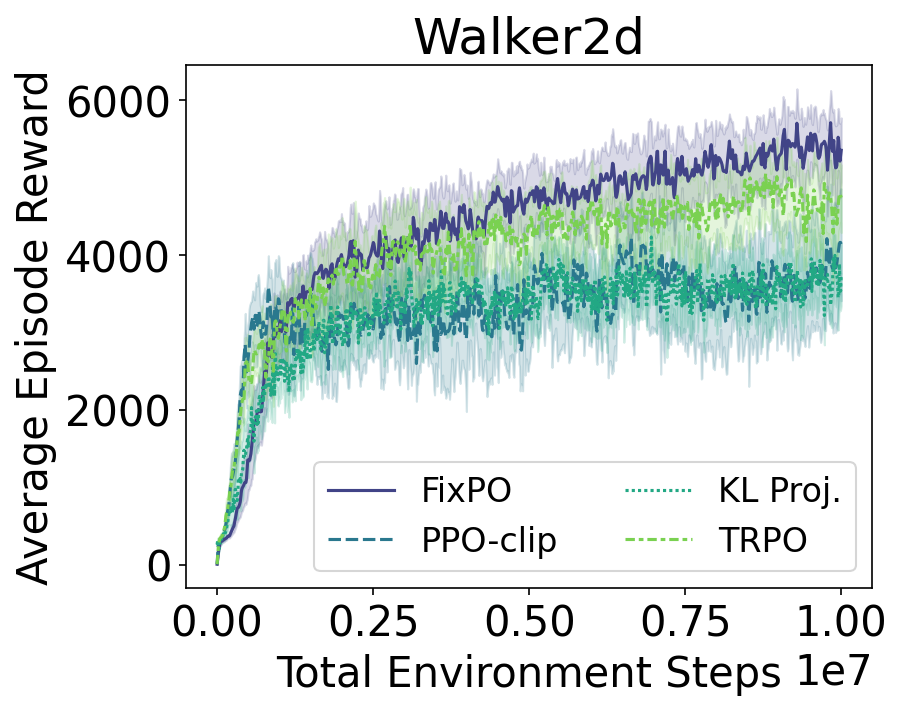

In [38]:
sns.lineplot(
    data=all_data,
    x="Total Environment Steps",
    y="Average Episode Reward",
    hue="Algorithm",
    ci=95,
    style="Algorithm",
    palette="viridis",
)
plt.legend(loc="lower right", ncol=2, prop={'size': 16})
plt.tight_layout()
plt.title(f"{env}")
plt.savefig(f"fixPo_vs_ppo_{env}.pdf", bbox_inches='tight')